In [98]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


def get_neighbors(base_rows, base_cols, i, j, method, scale=1):
    if type(scale) != int: raise ValueError("scale must be int")
    
    neighbors = []

    if method == "grid" or method == "dense_grid":
        directions = [(-scale, 0), (scale, 0), (0, -scale), (0, scale)]
        if method == "dense_grid":
            directions += [(-scale, -scale), (-scale, scale), (scale, -scale), (scale, scale)]

        for di, dj in directions:
            neighbor_row = i + di
            neighbor_col = (j + dj) % base_cols  # Periodic in east-west
            if 0 <= neighbor_row < base_rows:
                neighbors.append((neighbor_row, neighbor_col))

    return neighbors

        
def construct_adjacency_list(grid_size, method="grid", scales=None, origins=None, verbose=False):
    """
    Helper function: generates the adjacency list for a 24x72 grid of nodes.

    Params:
        method (str): base grid method. Options:
            "grid": connect each node to its 4 up-down-left-right neighbors.
            "dense_grid": connect each node to its 8 neighbors (including diagonals).
        scales (list of int): list of scales for generating downscaled grids. Each scale indicates the reduction factor.
        origins (list of tuple): list of origin tuples (row, col) for each downscaled grid. Should match the length of scales.

    Returns:
        np.array: adjacency list of shape (2, num_edges) 
    """
    rows, cols = grid_size
    adjacency_list = []

    if not scales:
        if origins: 
            raise ValueError("Cannot set `origins` if your scale is 1")
        scales = [1]

    if not origins:
        origins = [(0,0) for i in range(len(scales))]

    if len(scales) != len(origins):
            raise ValueError("`scales` and `origins` must have the same length.")

    for scale, origin in zip(scales, origins):
        for i in range(origin[0], rows, scale):
            for j in range(origin[1], cols, scale):
                curr_index = i * cols + j 

                neighbors = get_neighbors(rows, cols, i, j, method, scale=scale)
                if verbose: print(f"node {i,j} has neighbors {neighbors}")
                for neighbor_i, neighbor_j in neighbors:
                    neighbor_index = neighbor_i * cols + neighbor_j 
                    if verbose: print(f"appending {(curr_index, neighbor_index)}")
                    adjacency_list.append((curr_index, neighbor_index))

    adj_t = np.array(adjacency_list).T
    return adj_t

construct_adjacency_list((24, 72), method="grid", scales=[4], origins=[(0,0)])

array([[   0,    0,    0,    4,    4,    4,    8,    8,    8,   12,   12,
          12,   16,   16,   16,   20,   20,   20,   24,   24,   24,   28,
          28,   28,   32,   32,   32,   36,   36,   36,   40,   40,   40,
          44,   44,   44,   48,   48,   48,   52,   52,   52,   56,   56,
          56,   60,   60,   60,   64,   64,   64,   68,   68,   68,  288,
         288,  288,  288,  292,  292,  292,  292,  296,  296,  296,  296,
         300,  300,  300,  300,  304,  304,  304,  304,  308,  308,  308,
         308,  312,  312,  312,  312,  316,  316,  316,  316,  320,  320,
         320,  320,  324,  324,  324,  324,  328,  328,  328,  328,  332,
         332,  332,  332,  336,  336,  336,  336,  340,  340,  340,  340,
         344,  344,  344,  344,  348,  348,  348,  348,  352,  352,  352,
         352,  356,  356,  356,  356,  576,  576,  576,  576,  580,  580,
         580,  580,  584,  584,  584,  584,  588,  588,  588,  588,  592,
         592,  592,  592,  596,  596, 

In [173]:

def plot_graph(data, adjacency_list, plot_nodes, scale=1, rows=24, cols=72):
    """
    Plots the constructed graph for a 24x72 grid.

    Params:
        data (np.array): 24x72 array of data, including NaNs.
        adjacency_list (np.array): adjacency list of shape (2, num_edges).
        rows (int): number of rows in the grid.
        cols (int): number of columns in the grid.
        scales (list of int): list of scales for distinguishing different connections.
    """
    # Generate coordinates for each node in the grid
    y, x = np.meshgrid(range(rows), range(cols), indexing='ij')
    node_coords = np.vstack([x.ravel(), y.ravel()]).T  # Shape (num_nodes, 2)

    # Identify valid nodes (not NaN)
    valid_nodes = ~np.isnan(data.ravel())

    # Plot edges for each scale
    colors = plt.cm.Spectral(np.linspace(0,1,10))

    scale_edges = adjacency_list.T

    # Filter edges based on valid nodes
    valid_edges = scale_edges[
        valid_nodes[scale_edges[:, 0]] & valid_nodes[scale_edges[:, 1]]
    ]

    # Plot edges for the current scale
    for edge in valid_edges:
        x_coords = node_coords[edge, 0]
        y_coords = node_coords[edge, 1]
        plt.plot(x_coords, y_coords, color="tab:blue", alpha=0.6, linewidth=scale/3)

    # Plot nodes
    if plot_nodes:
        plt.scatter(node_coords[valid_nodes, 0], node_coords[valid_nodes, 1], c='k', s=3, zorder=3)


In [101]:
# Unit test
def test_get_neighbors():
    rows, cols = 24, 72

    # Test for "grid" method
    expected_grid_neighbors = [(1, 0), (0, 71), (0, 1)]
    grid_neighbors = get_neighbors(rows, cols, 0, 0, "grid")
    assert sorted(grid_neighbors) == sorted(expected_grid_neighbors), f"Grid neighbors incorrect: {grid_neighbors}"

    # Test for "dense_grid" method
    expected_dense_neighbors = [(1, 0), (0, 71), (0, 1), (1, 71), (1, 1)]
    dense_neighbors = get_neighbors(rows, cols, 0, 0, "dense_grid")
    assert sorted(dense_neighbors) == sorted(expected_dense_neighbors), f"Dense grid neighbors incorrect: {dense_neighbors}"

    print("All tests passed for base neighbors!")

def test_scale_4_grid():
    rows, cols = 24, 72
    scales = [4]
    origins = [(0, 0)]

    adjacency_list = construct_adjacency_list(grid_size=(24,72), method="grid", scales=scales, origins=origins)

    # Check edges for node (0,0)
    node_0 = 0
    scale_4_neighbors = [(0, 4), (4, 0), (0, 68)]  # Expected neighbors at scale 4
    scale_4_edges = [(node_0, n[0] * cols + n[1]) for n in scale_4_neighbors]

    for edge in scale_4_edges:
        assert any((edge[0] == e[0] and edge[1] == e[1]) or (edge[0] == e[1] and edge[1] == e[0]) for e in adjacency_list.T), \
            f"Edge {edge} not found in adjacency list for scale 4."

    # Check that no new scale 4 edges are added to (1,0) or (0,1)
    node_1_0 = 1 * cols + 0
    node_0_1 = 0 * cols + 1

    for edge in adjacency_list.T:
        assert edge[0] != node_1_0 and edge[1] != node_1_0, \
            f"Unexpected edge {edge} involving node (1,0)."
        assert edge[0] != node_0_1 and edge[1] != node_0_1, \
            f"Unexpected edge {edge} involving node (0,1)."

    print("All tests passed for scale 4 grid!")

# Run the unit tests
test_get_neighbors()
test_scale_4_grid()

All tests passed for base neighbors!
All tests passed for scale 4 grid!


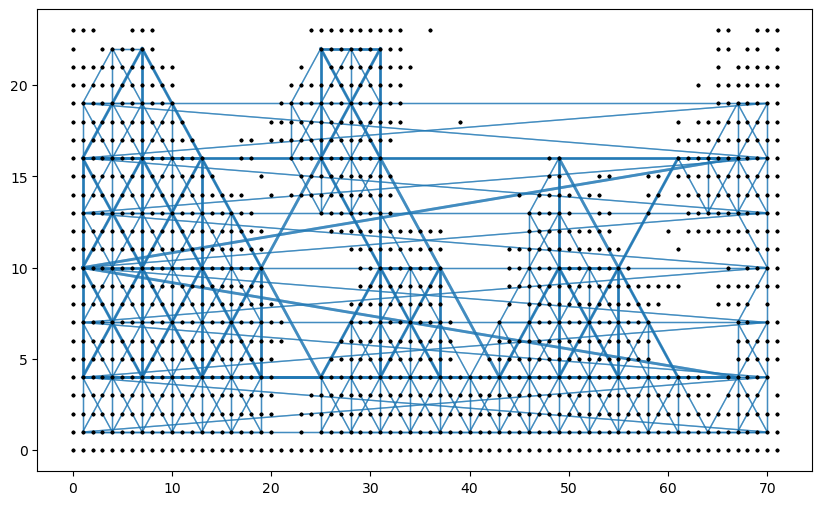

In [176]:

rows, cols = 24, 72
data = xr.open_dataset("/scratch/users/yucli/enso_data/merged_data/SODA.nc").sst.isel(time=0).values

adjacency_list1 = construct_adjacency_list(
    grid_size=(rows, cols),
    method="dense_grid",
    scales=[3],
    origins=[(1,1)]
)

adjacency_list2 = construct_adjacency_list(
    grid_size=(rows, cols),
    method="dense_grid",
    scales=[6],
    origins=[(4,1)]
)


plt.figure(figsize=(10,6))
plot_graph(data, adjacency_list1, scale=3, plot_nodes=True, rows=rows, cols=cols)
plot_graph(data, adjacency_list2, scale=6, plot_nodes=True, rows=rows, cols=cols)

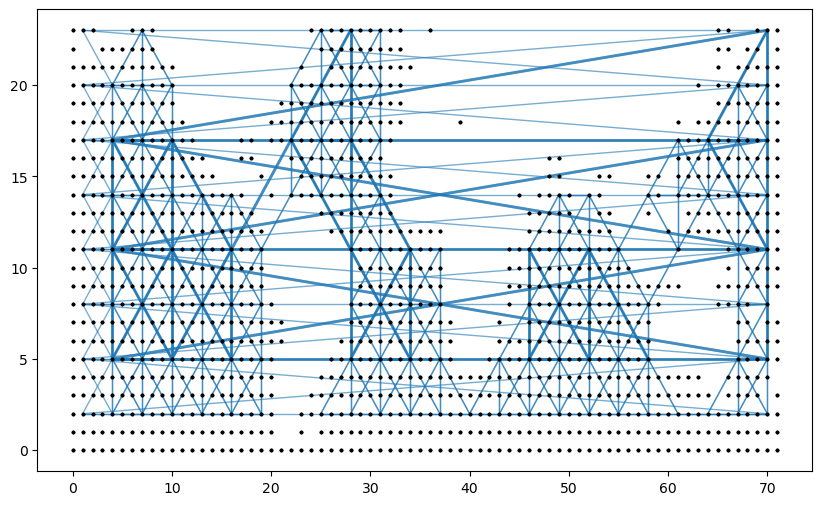

In [189]:
adjacency_list1 = construct_adjacency_list(
    grid_size=(rows, cols),
    method="dense_grid",
    scales=[1],
)

adjacency_list2 = construct_adjacency_list(
    grid_size=(rows, cols),
    method="dense_grid",
    scales=[3],
    origins=[(2,4)]
)

adjacency_list3 = construct_adjacency_list(
    grid_size=(rows, cols),
    method="dense_grid",
    scales=[6],
    origins=[(5,4)]
)


plt.figure(figsize=(10,6))
#plot_graph(data, adjacency_list1, scale=1, plot_nodes=True, rows=rows, cols=cols)
plot_graph(data, adjacency_list2, scale=3, plot_nodes=True, rows=rows, cols=cols)
plot_graph(data, adjacency_list3, scale=6, plot_nodes=True, rows=rows, cols=cols)